a general outline of the perceptron algorithm:

- Initialize the weight vector w and bias term b to zeros or random values.
- Iterate over the training data points (x, y), where x is the feature vector and y is the label (either 1 or -1).
- Calculate the output of the perceptron for the input vector x by computing the dot product of w and x and adding b. The output is y_hat.
- Update the weight vector and bias term based on the error between the predicted output y_hat and the actual label y. The update rule is:
- w = w + learning_rate * y * x
- b = b + learning_rate * y
where learning_rate is a hyperparameter that controls the step size of the updates.
- Repeat steps 2-4 until convergence or a maximum number of iterations is reached.

In [1]:
import time 
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
data= pd.read_csv('annotated_points_np_200.csv')
data

,x,y,labels
0,5.129032,19.155844,2.0
1,4.354839,16.168831,2.0
2,3.629032,15.909091,2.0
3,4.064516,12.662338,2.0
4,6.822581,12.792208,2.0
...,...,...,...
195,11.322581,28.961039,4.0
196,8.370968,29.350649,4.0
197,9.000000,27.987013,4.0
198,20.854839,25.584416,4.0


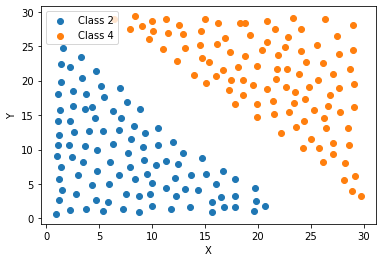

In [3]:
# Extract the points labeled as class 2 and class 4
class_2_points = data[data['labels'] == 2]
class_4_points = data[data['labels'] == 4]

# Create a scatterplot of the two classes
plt.scatter(class_2_points['x'], class_2_points['y'], label='Class 2')
plt.scatter(class_4_points['x'], class_4_points['y'], label='Class 4')

# Add axis labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

In [4]:
# Extract the features and labels
features = data[['x', 'y']].values
labels = data['labels'].values

# Convert the data to cupy arrays
features = cp.array(features)
labels = cp.array(labels)

# Normalize the features
features = (features - features.mean(axis=0)) / features.std(axis=0)


In [31]:
# Shuffle the data
np.random.seed(42)
shuffle_idx = np.random.permutation(len(features))
features = features[shuffle_idx]
labels = labels[shuffle_idx]

# # Split the data into training, validation, and testing sets
# train_size = int(0.6 * len(features))
# val_size = int(0.2 * len(features))
# train_features, train_labels = features[:train_size], labels[:train_size]
# val_features, val_labels = features[train_size:train_size+val_size], labels[train_size:train_size+val_size]
# test_features, test_labels = features[train_size+val_size:], labels[train_size+val_size:]


In [32]:
def perceptron(features, labels, learning_rate=0.001, num_epochs=100, weights=None,specific_weights=None):
    if weights is None:
        # Initialize the weights to zeros
        weights = cp.zeros(features.shape[1])
    elif weights == 'random':
        # Initialize the weights to random values between -1 and 1
        weights = cp.random.uniform(-1, 1, features.shape[1])
    elif weights == 'from_data':
        # Initialize the weights to the feature means
        weights = features.mean(axis=0)
    else:
        raise ValueError(f'Invalid value for weights: {weights}')

    if specific_weights is not None:
        # Initialize the weights to the specific values provided
        weights = cp.array(specific_weights)
    
    bias = 0.0
    errors = []
    
    # Train the perceptron for num_epochs
    for epoch in range(int(num_epochs)):
        # Shuffle the training data
        shuffle_idx = cp.random.permutation(len(features))
        features = features[shuffle_idx]
        labels = labels[shuffle_idx]
        
        # Perform one pass over the training data
        error_count = 0
        dw = cp.zeros_like(weights)
        db = 0.0
        for i in range(len(features)):
            x = features[i]
            y = labels[i]
            y_pred = cp.dot(x, weights) + bias
            if y * y_pred <= 0:
                dw += y * x
                db += y
                error_count += 1
        weights += learning_rate * dw
        bias += learning_rate * db
        errors.append(error_count)
        
        # Print the training progress
        print(f'Epoch {epoch+1}/{num_epochs}: error count = {error_count}')
        
        # Check for convergence
        if error_count == 0:
            print('Converged')
            break
    
    # Compute the decision boundary
    xx = cp.linspace(features[:,0].min(), features[:,0].max(), 100)
    yy = -(weights[0]/weights[1]) * xx - (bias/weights[1])
    
    # Return the decision boundary and the trained weights and bias
    return xx, yy, weights, bias, errors

In [162]:
# def plot_decision_boundary(xx, yy, features, labels):
#     # Map label values to colors
#     colors = {2: 'b', 4: 'r'}
#     label_colors = [colors[label] for label in labels.get()]
#     # Label the data points as class 1 or class 2
#     labels = labels.copy()
#     labels[labels == 2] = 1
#     labels[labels == 4] = 2
#     plt.plot(xx.get(), yy.get(), 'k-',label='Decision Boundary')
#     # Plot the features and labels
#     plt.scatter(features[:, 0].get(), features[:, 1].get(), c=labels.get(), cmap='bwr', label='Class 1 (blue) and Class 2 (red)')
#     plt.legend()

In [33]:
def plot_decision_boundary(xx, yy, features, labels):
    # Map label values to colors
    colors = {2: 'b', 4: 'r'}
    label_colors = [colors[label] for label in labels.get()]
    
    # Label the data points as class 1 or class 2
    labels = labels.copy()
    labels[labels == 2] = 1
    labels[labels == 4] = 2
    
    # Plot the decision boundary
    plt.plot(xx.get(), yy.get(), 'k-', label='Decision Boundary')
    
    # Plot the features and labels
    plt.scatter(features[labels==1, 0].get(), features[labels==1, 1].get(), c='r', cmap='bwr', label='Class 1 (red)')
    plt.scatter(features[labels==2, 0].get(), features[labels==2, 1].get(), c='b', cmap='bwr', label='Class 2 (blue)')
    plt.legend()


Epoch 1/100: error count = 200
Epoch 2/100: error count = 0
Converged


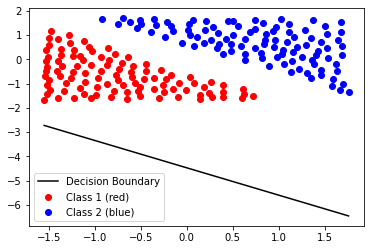

In [34]:
# #Train the perceptron on the training set using zeros initialization
xx, yy, weights, bias, errors = perceptron(features, labels,weights=None)
plot_decision_boundary(xx, yy, features, labels)


Epoch 1/100: error count = 98
Epoch 2/100: error count = 61
Epoch 3/100: error count = 23
Epoch 4/100: error count = 4
Epoch 5/100: error count = 2
Epoch 6/100: error count = 1
Epoch 7/100: error count = 1
Epoch 8/100: error count = 1
Epoch 9/100: error count = 1
Epoch 10/100: error count = 0
Converged


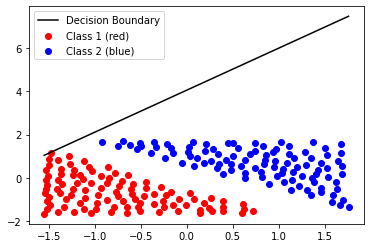

In [35]:
# Train the perceptron on the training set using random initialization
xx,yy,weights, bias, errors= perceptron(features, labels, weights='random')
plot_decision_boundary(xx, yy, features, labels)

Epoch 1/100: error count = 99
Epoch 2/100: error count = 49
Epoch 3/100: error count = 4
Epoch 4/100: error count = 1
Epoch 5/100: error count = 1
Epoch 6/100: error count = 1
Epoch 7/100: error count = 0
Converged


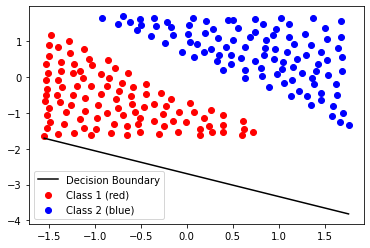

In [36]:
# Train the perceptron on the training set using feature means initialization
xx,yy,weights, bias, errors= perceptron(features, labels, weights='from_data')
plot_decision_boundary(xx, yy, features, labels)

### Finding the best hyperparameters when weights are initialised to Zero on the validation set

In [11]:


learning_rates = cp.arange(0.001, 0.01, 0.001)
num_epochs_list = cp.arange(100, 400, 100)

best_params = None
best_val_error = float('inf')

for learning_rate in learning_rates:
    for num_epochs in num_epochs_list:
        # Train the model on the training set
        xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=learning_rate, num_epochs=num_epochs, weights=None)

        # Evaluate the model on the validation set
        val_errors = []
        for i in range(len(val_features)):
            x = val_features[i]
            y = val_labels[i]
            y_pred = cp.sign(cp.dot(x, weights) + bias)
            if y * y_pred <= 0:
                val_errors.append(1)
            else:
                val_errors.append(0)
        val_error = sum(val_errors) / len(val_errors)

        # Print the validation error for this combination of hyperparameters
        print(f'learning_rate={learning_rate}, num_epochs={num_epochs}, weights=random, val_error={val_error}')

        # Check if this is the best combination of hyperparameters so far
        if val_error < best_val_error:
            best_params = (learning_rate, num_epochs, 'random')
            best_val_error = val_error

print(f'Best hyperparameters and weights: learning_rate={best_params[0]}, num_epochs={best_params[1]}, weights={best_params[2]}, val_error={best_val_error}')


Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
learning_rate=0.001, num_epochs=100, weights=random, val_error=0.0
Epoch 1/200: error count = 120
Epoch 2/200: error count = 0
Converged
learning_rate=0.001, num_epochs=200, weights=random, val_error=0.0
Epoch 1/300: error count = 120
Epoch 2/300: error count = 0
Converged
learning_rate=0.001, num_epochs=300, weights=random, val_error=0.0
Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
learning_rate=0.002, num_epochs=100, weights=random, val_error=0.0
Epoch 1/200: error count = 120
Epoch 2/200: error count = 0
Converged
learning_rate=0.002, num_epochs=200, weights=random, val_error=0.0
Epoch 1/300: error count = 120
Epoch 2/300: error count = 0
Converged
learning_rate=0.002, num_epochs=300, weights=random, val_error=0.0
Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
learning_rate=0.003, num_epochs=100, weights=random, val_error=0.0
Epoch 1/200: error count = 120
Epoch 2/20

In [244]:
# learning_rates = [0.001, 0.01, 0.1]
# num_epochs_list = [100, 200, 300]

# best_params = None
# best_val_error = float('inf')

# for learning_rate in learning_rates:
#     for num_epochs in num_epochs_list:
#         # Train the model on the training set
#         xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=learning_rate, num_epochs=num_epochs)

#         # Evaluate the model on the validation set
#         val_errors = []
#         for i in range(len(val_features)):
#             x = val_features[i]
#             y = val_labels[i]
#             y_pred = cp.sign(cp.dot(x, weights) + bias)
#             if y * y_pred <= 0:
#                 val_errors.append(1)
#             else:
#                 val_errors.append(0)
#         val_error = sum(val_errors) / len(val_errors)

#         # Print the validation error for this combination of hyperparameters
#         print(f'learning_rate={learning_rate}, num_epochs={num_epochs}, weights=None, val_error={val_error}')

#         # Check if this is the best combination of hyperparameters so far
#         if val_error < best_val_error:
#             best_params = (learning_rate, num_epochs, None)
#             best_val_error = val_error

# print(f'Best hyperparameters and weights: learning_rate={best_params[0]}, num_epochs={best_params[1]}, weights={best_params[2]}, val_error={best_val_error}')


Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
learning_rate=0.001, num_epochs=100, weights=None, val_error=0.0
Epoch 1/200: error count = 120
Epoch 2/200: error count = 0
Converged
learning_rate=0.001, num_epochs=200, weights=None, val_error=0.0
Epoch 1/300: error count = 120
Epoch 2/300: error count = 0
Converged
learning_rate=0.001, num_epochs=300, weights=None, val_error=0.0
Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
learning_rate=0.01, num_epochs=100, weights=None, val_error=0.0
Epoch 1/200: error count = 120
Epoch 2/200: error count = 0
Converged
learning_rate=0.01, num_epochs=200, weights=None, val_error=0.0
Epoch 1/300: error count = 120
Epoch 2/300: error count = 0
Converged
learning_rate=0.01, num_epochs=300, weights=None, val_error=0.0
Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
learning_rate=0.1, num_epochs=100, weights=None, val_error=0.0
Epoch 1/200: error count = 120
Epoch 2/200: error count = 0


### Using the best hyperparameters obtained from the validation data we are checking it for the test set and plotting it

Epoch 1/100: error count = 120
Epoch 2/100: error count = 0
Converged
Test error: 0.0


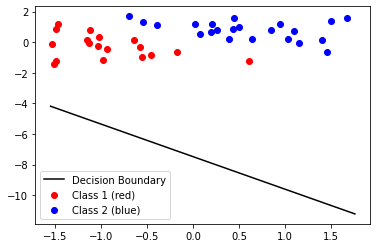

In [12]:
# Train the model on the training set with the best hyperparameters and weights
xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=0.001, num_epochs=100, weights=None)

# Evaluate the model on the test set
test_errors = []
for i in range(len(test_features)):
    x = test_features[i]
    y = test_labels[i]
    y_pred = cp.sign(cp.dot(x, weights) + bias)
    if y * y_pred <= 0:
        test_errors.append(1)
    else:
        test_errors.append(0)
test_error = sum(test_errors) / len(test_errors)

# Print the test error
print(f'Test error: {test_error}')

# Plot the decision boundary and test set
plot_decision_boundary(xx, yy, test_features, test_labels)
plt.show()


### Finding the best hyperparameters from the validation set when the weights are initialised to random

In [13]:
learning_rates = [0.001, 0.01, 0.1]
num_epochs_list = [100, 200, 300]

best_params = None
best_val_error = float('inf')

for learning_rate in learning_rates:
    for num_epochs in num_epochs_list:
        # Train the model on the training set
        xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=learning_rate, num_epochs=num_epochs, weights='random')

        # Evaluate the model on the validation set
        val_errors = []
        for i in range(len(val_features)):
            x = val_features[i]
            y = val_labels[i]
            y_pred = cp.sign(cp.dot(x, weights) + bias)
            if y * y_pred <= 0:
                val_errors.append(1)
            else:
                val_errors.append(0)
        val_error = sum(val_errors) / len(val_errors)

        # Print the validation error for this combination of hyperparameters
        print(f'learning_rate={learning_rate}, num_epochs={num_epochs}, weights=random, val_error={val_error}')

        # Check if this is the best combination of hyperparameters so far
        if val_error < best_val_error:
            best_params = (learning_rate, num_epochs, 'random')
            best_val_error = val_error

print(f'Best hyperparameters and weights: learning_rate={best_params[0]}, num_epochs={best_params[1]}, weights={best_params[2]}, val_error={best_val_error}')


Epoch 1/100: error count = 59
Epoch 2/100: error count = 48
Epoch 3/100: error count = 38
Epoch 4/100: error count = 30
Epoch 5/100: error count = 20
Epoch 6/100: error count = 8
Epoch 7/100: error count = 6
Epoch 8/100: error count = 3
Epoch 9/100: error count = 1
Epoch 10/100: error count = 1
Epoch 11/100: error count = 0
Converged
learning_rate=0.001, num_epochs=100, weights=random, val_error=0.025
Epoch 1/200: error count = 63
Epoch 2/200: error count = 57
Epoch 3/200: error count = 47
Epoch 4/200: error count = 29
Epoch 5/200: error count = 4
Epoch 6/200: error count = 2
Epoch 7/200: error count = 1
Epoch 8/200: error count = 0
Converged
learning_rate=0.001, num_epochs=200, weights=random, val_error=0.0
Epoch 1/300: error count = 56
Epoch 2/300: error count = 23
Epoch 3/300: error count = 0
Converged
learning_rate=0.001, num_epochs=300, weights=random, val_error=0.0
Epoch 1/100: error count = 63
Epoch 2/100: error count = 22
Epoch 3/100: error count = 0
Converged
learning_rate=0.0

### Plotting and evaluating the best hyperparameter obtained in the validation set with weights initialized to  random

Epoch 1/200: error count = 62
Epoch 2/200: error count = 50
Epoch 3/200: error count = 36
Epoch 4/200: error count = 17
Epoch 5/200: error count = 5
Epoch 6/200: error count = 2
Epoch 7/200: error count = 1
Epoch 8/200: error count = 0
Converged
Validation error with best hyperparameters and weights: 0.0


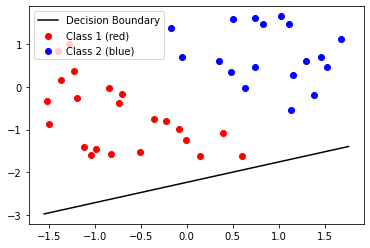

In [14]:
# Train the model on the training set with the best hyperparameters and weights
xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=0.001, num_epochs=200, weights='random')

# Evaluate the model on the validation set
val_errors = []
for i in range(len(val_features)):
    x = val_features[i]
    y = val_labels[i]
    y_pred = cp.sign(cp.dot(x, weights) + bias)
    if y * y_pred <= 0:
        val_errors.append(1)
    else:
        val_errors.append(0)
val_error = sum(val_errors) / len(val_errors)

# Print the validation error
print(f'Validation error with best hyperparameters and weights: {val_error}')

# Plot the decision boundary and validation set
plot_decision_boundary(xx, yy, val_features, val_labels)
plt.show()


### Using the best hyperparameters obtained from the validation set we are evaluating it on the test set for weights initialised to random

Epoch 1/200: error count = 60
Epoch 2/200: error count = 58
Epoch 3/200: error count = 51
Epoch 4/200: error count = 41
Epoch 5/200: error count = 26
Epoch 6/200: error count = 10
Epoch 7/200: error count = 3
Epoch 8/200: error count = 1
Epoch 9/200: error count = 1
Epoch 10/200: error count = 0
Converged
Test error: 0.0


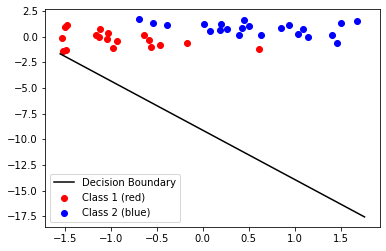

In [15]:
# Train the model on the training set with the best hyperparameters and weights
xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=0.001, num_epochs=200, weights='random')

# Evaluate the model on the test set
test_errors = []
for i in range(len(test_features)):
    x = test_features[i]
    y = test_labels[i]
    y_pred = cp.sign(cp.dot(x, weights) + bias)
    if y * y_pred <= 0:
        test_errors.append(1)
    else:
        test_errors.append(0)
test_error = sum(test_errors) / len(test_errors)

# Print the test error
print(f'Test error: {test_error}')

# Plot the decision boundary and test set
plot_decision_boundary(xx, yy, test_features, test_labels)
plt.show()


### Finding the best hyper parameter in the validation set when weights initialised from data

In [16]:
learning_rates = [0.001, 0.01, 0.1]
num_epochs_list = [100, 200, 300]

best_params = None
best_val_error = float('inf')

for learning_rate in learning_rates:
    for num_epochs in num_epochs_list:
        # Train the model on the training set
        xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=learning_rate, num_epochs=num_epochs, weights= 'from_data')

        # Evaluate the model on the validation set
        val_errors = []
        for i in range(len(val_features)):
            x = val_features[i]
            y = val_labels[i]
            y_pred = cp.sign(cp.dot(x, weights) + bias)
            if y * y_pred <= 0:
                val_errors.append(1)
            else:
                val_errors.append(0)
        val_error = sum(val_errors) / len(val_errors)

        # Print the validation error for this combination of hyperparameters
        print(f'learning_rate={learning_rate}, num_epochs={num_epochs}, weights= from_data, val_error={val_error}')

        # Check if this is the best combination of hyperparameters so far
        if val_error < best_val_error:
            best_params = (learning_rate, num_epochs,  'from_data')
            best_val_error = val_error

print(f'Best hyperparameters and weights: learning_rate={best_params[0]}, num_epochs={best_params[1]}, weights={best_params[2]}, val_error={best_val_error}')


Epoch 1/100: error count = 53
Epoch 2/100: error count = 4
Epoch 3/100: error count = 1
Epoch 4/100: error count = 0
Converged
learning_rate=0.001, num_epochs=100, weights= from_data, val_error=0.0
Epoch 1/200: error count = 53
Epoch 2/200: error count = 4
Epoch 3/200: error count = 1
Epoch 4/200: error count = 0
Converged
learning_rate=0.001, num_epochs=200, weights= from_data, val_error=0.0
Epoch 1/300: error count = 53
Epoch 2/300: error count = 4
Epoch 3/300: error count = 1
Epoch 4/300: error count = 0
Converged
learning_rate=0.001, num_epochs=300, weights= from_data, val_error=0.0
Epoch 1/100: error count = 53
Epoch 2/100: error count = 28
Epoch 3/100: error count = 0
Converged
learning_rate=0.01, num_epochs=100, weights= from_data, val_error=0.0
Epoch 1/200: error count = 53
Epoch 2/200: error count = 28
Epoch 3/200: error count = 0
Converged
learning_rate=0.01, num_epochs=200, weights= from_data, val_error=0.0
Epoch 1/300: error count = 53
Epoch 2/300: error count = 28
Epoch 3/

### Using the best hyperparameter obtained from the validation, plotting and evaluating it for the validation set when weights initialised to from data

Epoch 1/100: error count = 53
Epoch 2/100: error count = 4
Epoch 3/100: error count = 1
Epoch 4/100: error count = 0
Converged
Validation error: 0.0


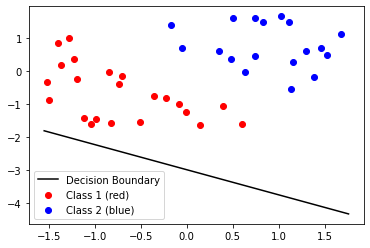

In [17]:
# Train the model with the best hyperparameters on the training set
xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=0.001, num_epochs=100, weights='from_data')

# Evaluate the model on the validation set
val_errors = []
for i in range(len(val_features)):
    x = val_features[i]
    y = val_labels[i]
    y_pred = cp.sign(cp.dot(x, weights) + bias)
    if y * y_pred <= 0:
        val_errors.append(1)
    else:
        val_errors.append(0)
val_error = sum(val_errors) / len(val_errors)

print(f'Validation error: {val_error}')

# Plot the decision boundary and test set
plot_decision_boundary(xx, yy, val_features, val_labels)
plt.show()


### Using the best hyperparameters obtained from the val set we are plotting the test when weights are initialised to from data

Epoch 1/100: error count = 53
Epoch 2/100: error count = 4
Epoch 3/100: error count = 1
Epoch 4/100: error count = 0
Converged
Test error: 0.0


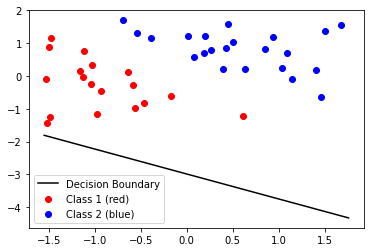

In [18]:
# Train the model on the training set with the best hyperparameters and weights
xx, yy, weights, bias, train_errors = perceptron(train_features, train_labels, learning_rate=0.001, num_epochs=100, weights='from_data')

# Evaluate the model on the test set
test_errors = []
for i in range(len(test_features)):
    x = test_features[i]
    y = test_labels[i]
    y_pred = cp.sign(cp.dot(x, weights) + bias)
    if y * y_pred <= 0:
        test_errors.append(1)
    else:
        test_errors.append(0)
test_error = sum(test_errors) / len(test_errors)

# Print the test error
print(f'Test error: {test_error}')

# Plot the decision boundary and test set
plot_decision_boundary(xx, yy, test_features, test_labels)
plt.show()
